<a href="https://colab.research.google.com/github/opatil31/SplineNeck-AE-InterpDimReduction/blob/main/SplineNeck_ZINB_Semi_Supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy anndata scanpy gseapy umap-learn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.6/171.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 156.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.0/80.0 kB 7.9 MB/s eta 0:00:00


In [ ]:
!wget https://openproblems-data.s3.amazonaws.com/resources/datasets/openproblems_v1/mouse_blood_olsson_labelled/log_cp10k/dataset.h5ad

--2025-11-05 19:37:54--  https://openproblems-data.s3.amazonaws.com/resources/datasets/openproblems_v1/mouse_blood_olsson_labelled/log_cp10k/dataset.h5ad
Resolving openproblems-data.s3.amazonaws.com (openproblems-data.s3.amazonaws.com)... 52.218.232.203, 52.92.233.65, 52.92.148.89, ...
Connecting to openproblems-data.s3.amazonaws.com (openproblems-data.s3.amazonaws.com)|52.218.232.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123102166 (117M) [binary/octet-stream]
Saving to: ‘dataset.h5ad’

dataset.h5ad        100%[===================>] 117.40M  12.7MB/s    in 9.6s    

2025-11-05 19:38:04 (12.3 MB/s) - ‘dataset.h5ad’ saved [123102166/123102166]



In [ ]:
import numpy as np
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from umap import UMAP

try:
    adata = sc.read_h5ad("dataset.h5ad")
    print("--- Data Loaded ---")
    print(adata)
except FileNotFoundError:
    print("Error: dataset.h5ad not found.")
    print("Please download it first using the wget command in your prompt.")
    exit()

--- Data Loaded ---
AnnData object with n_obs × n_vars = 660 × 116918
    obs: 'celltype', 'n_counts', 'cell_type', 'size_factors'
    var: 'n_cells', 'feature_name', 'hvg', 'hvg_score'
    uns: '_from_cache', 'data_reference', 'data_url', 'dataset_description', 'dataset_id', 'dataset_name', 'dataset_organism', 'dataset_reference', 'dataset_summary', 'dataset_url', 'knn', 'neighbors', 'normalization_id', 'pca_variance', 'umap', 'var_names_all'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'pca_loadings'
    layers: 'counts', 'normalized'
    obsp: 'connectivities', 'distances', 'knn_connectivities', 'knn_distances'


#Pre-Processing Count Data in RNA-seq

In the original dataset given from OpenProblems-Bio, there are multiple different features corresponding to the same gene, as such we need to sum all of their various counts for that gene

In [ ]:
import pandas as pd
import anndata as ad
import numpy as np
import scipy.sparse as sp

# 1. Get the "base" gene name for every column
print("Identifying unique base gene names...")
base_gene_names = adata.var_names.to_series().str.split('-').str[0]
adata.var['base_gene_name'] = base_gene_names

# 2. Get the list of unique base names
unique_base_genes = adata.var['base_gene_name'].unique()
print(f"Original n_vars: {adata.n_vars}")
print(f"New, unique n_vars: {len(unique_base_genes)}")

# 3. Create the new, corrected data matrix
print("Using data from adata.layers['counts']")
if sp.issparse(adata.layers['counts']):
    X_dense = adata.layers['counts'].toarray()
else:
    X_dense = adata.layers['counts']

# Create a new empty matrix to hold the corrected data
X_corrected = np.zeros((adata.n_obs, len(unique_base_genes)))

print("Summing duplicated gene columns...")
for i, base_name in enumerate(unique_base_genes):
    duplicate_indices = np.where(adata.var['base_gene_name'] == base_name)[0]
    duplicate_data = X_dense[:, duplicate_indices]

    sum_expression = duplicate_data.sum(axis=1)
    X_corrected[:, i] = sum_expression

print("Matrix correction complete.")

# 4. Create the new, clean AnnData object
# This object now contains the raw, aggregated counts
adata_new_counts = ad.AnnData(X=X_corrected, obs=adata.obs.copy())
adata_new_counts.var_names = unique_base_genes
adata_new_counts.var_names.name = 'gene_name'

print("\n--- New, Corrected COUNT AnnData Object ---")
print(adata_new_counts)

Identifying unique base gene names...
Original n_vars: 116918
New, unique n_vars: 16288
Using data from adata.layers['counts']
Summing duplicated gene columns...
Matrix correction complete.

--- New, Corrected COUNT AnnData Object ---
AnnData object with n_obs × n_vars = 660 × 16288
    obs: 'celltype', 'n_counts', 'cell_type', 'size_factors'


#Architecture Definitions for Spline-Neck

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import anndata as ad
import scanpy as sc
import scipy.sparse as sp
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
import warnings


def B_batch_autograd(x, grid, k=0, extend=True, device='cpu'):
    '''
    Evaluate x on B-spline bases iteratively to support autograd.
    Args:
        x (torch.Tensor): Input features, shape (batch_size, in_dim)
        grid (torch.Tensor): Knot locations, shape (in_dim, grid_size)
        k (int): Spline order.
        extend (bool): Ignored (matches original function signature).
        device (str): Ignored (matches original function signature, assumes tensors are already on the correct device).
    Returns:
        torch.Tensor: B-spline basis values, shape (batch_size, in_dim, grid_size - k - 1)
    '''
    # Unsqueeze for broadcasting
    # x shape: (batch_size, in_dim) -> (batch_size, in_dim, 1)
    x = x.unsqueeze(dim=2)
    # grid shape: (in_dim, grid_size) -> (1, in_dim, grid_size)
    grid = grid.unsqueeze(dim=0)
    # --- Base Case: k = 0 ---
    # This is the starting point for our iteration.
    # B shape: (batch_size, in_dim, grid_size - 1)
    B = (x >= grid[:, :, :-1]) * (x < grid[:, :, 1:])
    B = B.float()
    # --- Iterative Step: k = 1 to k_order ---
    # This loop unrolls the recursion, making it autograd-friendly.
    # We loop from k_i = 1 up to the target order k.
    for k_i in range(1, k + 1):
        # Get the correct grid slices for this iteration (k_i)
        grid_0 = grid[:, :, :-(k_i + 1)]
        grid_k = grid[:, :, k_i:-1]
        grid_1 = grid[:, :, 1:(-k_i)]
        grid_k_plus_1 = grid[:, :, k_i + 1:]
        # Denominators (with epsilon for numerical stability)
        denom1 = grid_k - grid_0 + 1e-8
        denom2 = grid_k_plus_1 - grid_1 + 1e-8

        # B_km1 is the tensor 'B' from the *previous* iteration
        B_prev_first = B[:, :, :-1]
        B_prev_second = B[:, :, 1:]

        # Numerators
        num1 = x - grid_0
        num2 = grid_k_plus_1 - x

        # Cox-de Boor formula
        term1 = (num1 / denom1) * B_prev_first
        term2 = (num2 / denom2) * B_prev_second

        # Update B for the next iteration
        B = term1 + term2

    B = torch.nan_to_num(B)

    return B.float()

def coef_to_curve(x_eval, grid, coef, k, device="cpu"):
    ''' converting B-spline coefficients to B-spline curves. '''
    b_splines = B_batch_autograd(x_eval, grid, k=k)
    y_eval = torch.einsum('bik,iok->bio', b_splines, coef.to(b_splines.device))
    return y_eval

class SplineNeck(nn.Module):
    """
    The "Spline-Neck" layer.

    This is an additive (GAM-style) layer that learns an independent
    B-spline transformation for each input feature.

    Args:
        is_gated (bool): If True, applies a hard-gate (x=0 -> y=0)
                         to preserve input sparsity. This is essential
                         for the encoder's first layer.
    """
    def __init__(self, input_dim, grid_num=10, grid_range=[-1, 1], k=3, is_gated=False):
        super(SplineNeck, self).__init__()
        self.k = k
        self.grid_num = grid_num
        self.input_dim = input_dim
        self.is_gated = is_gated # Store the gate flag

        # Create the internal grid knots
        internal_grid = torch.einsum('i,j->ij',
                                     torch.ones(input_dim),
                                     torch.linspace(grid_range[0], grid_range[1], steps=grid_num + 1))

        # Extend the grid to add knots at the boundaries
        extended_grid = self._extend_grid(internal_grid, k)
        self.register_buffer('grid', extended_grid)

        # The number of coefficients is (number of internal knots + 1) + k
        n_coef = grid_num + k

        # Initialize coefficients for each spline
        # Shape: (in_dim, 1, n_coef)
        self.coef = nn.Parameter(torch.randn(input_dim, 1, n_coef) * 0.1)

    @staticmethod
    def _extend_grid(grid, k):
        """Extends the grid by k knots on each side."""
        h = (grid[:, -1] - grid[:, 0]) / (grid.shape[1] - 1)
        h = h.unsqueeze(1)

        extended_grid = grid
        for i in range(k):
            # Prepend a knot
            extended_grid = torch.cat([extended_grid[:, 0:1] - h, extended_grid], dim=1)
            # Append a knot
            extended_grid = torch.cat([extended_grid, extended_grid[:, -1:] + h], dim=1)
        return extended_grid

    def forward(self, x):
        # x shape: (batch_size, in_dim)

        # y_eval shape: (batch_size, in_dim, 1)
        y_eval = coef_to_curve(
            x_eval=x,
            grid=self.grid,
            coef=self.coef,
            k=self.k,
            device=x.device
        )

        if self.is_gated:
            # Create a binary mask: 1.0 for non-zeros, 0.0 for zeros
            mask = (x != 0).float()
            # Apply the mask
            # mask.unsqueeze(-1) shape: (batch_size, in_dim, 1)
            y_eval = y_eval * mask.unsqueeze(-1)

        # Squeeze final dim to get shape: (batch_size, in_dim)
        return y_eval.squeeze(-1)


class SplineNeckAE_ZINB(nn.Module):
    """
    SplineNeck Autoencoder with ZINB output heads.
    """
    def __init__(self, n_input, latent_dim, n_classes, grid_num=10, grid_range=[-1, 1], k=3):
        super(SplineNeckAE_ZINB, self).__init__()
        self.n_input = n_input
        self.latent_dim = latent_dim

        # SplineNeck (gated) -> Linear
        # We set is_gated=True, which is essential for sparse count data
        self.encoder = nn.Sequential(
            SplineNeck(n_input, grid_num, grid_range, k, is_gated=True),
            nn.Linear(n_input, latent_dim)
        )

        # Three separate "heads" all starting from the latent vector h.

        # Head 1: Predicts 'mu' (the mean)
        # This is the interpretable Linear -> SplineNeck design
        self.decoder_mu = nn.Sequential(
            nn.Linear(latent_dim, n_input),
            nn.Softplus()
        )

        # Head 2: Predicts 'theta' (the dispersion)
        # Linear -> Softplus (to ensure theta is positive)
        self.decoder_theta = nn.Sequential(
            nn.Linear(latent_dim, n_input),
            nn.Softplus()
        )

        # Head 3: Predicts 'pi' (the dropout probability)
        # Linear -> Sigmoid (to ensure pi is between 0 and 1)
        self.decoder_pi = nn.Sequential(
            nn.Linear(latent_dim, n_input),
            nn.Sigmoid()
        )

        self.classifier = nn.Linear(latent_dim, n_classes)

    def encode(self, x):
        h = self.encoder(x)
        return h

    def decode(self, h):
        # Decode all three parameters from the latent code h
        mu = self.decoder_mu(h)
        theta = self.decoder_theta(h)
        pi = self.decoder_pi(h)
        return mu, theta, pi

    def forward(self, x):
        h = self.encode(x)
        mu, theta, pi = self.decode(h)
        logits = self.classifier(h)
        return mu, theta, pi, h, logits

#Zero-Inflated Negative Binomial (ZINB) Loss

In [ ]:
class ZINBLoss(nn.Module):
    """
    ZINB Negative Log-Likelihood Loss.
    """
    def __init__(self, eps=1e-8):
        super(ZINBLoss, self).__init__()
        self.eps = eps # Epsilon for numerical stability (to avoid log(0))

    def forward(self, x, mu, theta, pi):
        # x: raw count data
        # mu, theta, pi: parameters from the decoder

        # Ensure theta is stable
        theta = torch.clamp(theta, min=self.eps)

        # --- Negative Binomial Log-Likelihood ---
        # This is log(NB(x | mu, theta))
        lgamma = torch.lgamma
        log_nb = (
            lgamma(x + theta)
            - lgamma(x + 1)
            - lgamma(theta)
            + theta * torch.log(theta / (theta + mu + self.eps) + self.eps)
            + x * torch.log(mu / (theta + mu + self.eps) + self.eps)
        )

        # --- ZINB Log-Likelihood ---
        # This combines the "dropout" (pi) with the NB (1-pi)

        # Case 1: x == 0
        # log(pi + (1-pi) * NB(0 | ...))
        log_nb_zero = theta * torch.log(theta / (theta + mu + self.eps) + self.eps)
        log_case_zero = torch.log(pi + (1 - pi) * torch.exp(log_nb_zero) + self.eps)

        # Case 2: x > 0
        # log((1-pi) * NB(x | ...))
        log_case_non_zero = torch.log(1 - pi + self.eps) + log_nb

        # Combine cases
        log_zinb = torch.where(x < self.eps, log_case_zero, log_case_non_zero)

        # Return the NLL (negative of the log-likelihood), averaged
        return -torch.mean(log_zinb)

#Training

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

try:
    _ = adata_new_counts
except NameError:
    print("ERROR: 'adata_new_counts' object not found.")
    print("Please run the new preprocessing script (Step 1) first.")
    raise

print("Creating normalized data for model input...")
adata_new_log = adata_new_counts.copy()
sc.pp.log1p(adata_new_log)
# Scale the data to be zero-center, unit-variance. This is crucial.
sc.pp.scale(adata_new_log, max_value=10)
print(adata_new_log)

print("Preparing PyTorch tensors...")
# This is the (log1p + scaled) data for INPUT
X_train_log_tensor = torch.tensor(adata_new_log.X.astype(np.float32))
# This is the (raw count) data for TARGET
X_train_counts_tensor = torch.tensor(adata_new_counts.X.astype(np.float32))

# Prepare Labels for Classification Head Part
print("Preparing cell type labels...")
labels_categorical = adata_new_counts.obs['cell_type']
label_map = {name: i for i, name in enumerate(labels_categorical.cat.categories)}
n_classes = len(label_map)

labels_int = labels_categorical.map(label_map).values
X_labels_tensor = torch.tensor(labels_int, dtype=torch.long)

print(f"Found {n_classes} classes: {label_map}")

train_dataset = TensorDataset(X_train_log_tensor, X_train_counts_tensor, X_labels_tensor)

# --- 2. Estimate Input Data Range (from COUNTS) ---
n_input = adata_new_log.n_vars
latent_dim = 2
print(f"Set n_input (n_vars) to: {n_input}")
print(f"Set latent_dim to: {latent_dim}")

data_min = X_train_log_tensor.min().item()
data_max = X_train_log_tensor.max().item()
print(f"NORMALIZED input data range: [{data_min:.2f}, {data_max:.2f}]")
data_range_buffered = [data_min - 0.1, data_max + 1.0]
print(f"Using buffered grid range: [{data_range_buffered[0]:.2f}, {data_range_buffered[1]:.2f}]")


# --- 3. Train SplineNeck-ZINB Autoencoder ---
print("\n--- Training SplineNeckAE_ZINB ---")
# Parameters
learning_rate = 1e-3
epochs = 200
batch_size = 64
grid_num_neck = 24
grid_range_neck = data_range_buffered
k_neck = 3

lambda_class = 10.0
lambda_var = 0

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize Model and Loss
model = SplineNeckAE_ZINB(
    n_input=n_input,
    latent_dim=latent_dim,
    n_classes = n_classes,
    grid_num=grid_num_neck,
    grid_range=grid_range_neck,
    k=k_neck
).to(device)

criterion_zinb = ZINBLoss().to(device)
criterion_class = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# --- Training Loop ---
for epoch in range(epochs):
  model.train()
  total_loss_zinb = 0
  total_loss_class = 0
  for inputs_normalized, targets_counts, target_labels in train_loader:
    inputs_normalized = inputs_normalized.to(device)
    targets_counts = targets_counts.to(device)
    target_labels = target_labels.to(device)

    # --- 1. Model sees NORMALIZED data ---
    mu, theta, pi, h_sparse, logits = model(inputs_normalized)

    # --- 2. Loss is calculated against RAW COUNT data ---
    loss_zinb = criterion_zinb(targets_counts, mu, theta, pi)

    loss_class = criterion_class(logits, target_labels)

    loss = loss_zinb + lambda_class * loss_class

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss_zinb += loss_zinb.item()
    total_loss_class += loss_class.item()

  if (epoch + 1) % 10 == 0:
    avg_loss_zinb = total_loss_zinb / len(train_loader)
    avg_loss_class = total_loss_class / len(train_loader)
    avg_loss_total = avg_loss_zinb + (lambda_class * avg_loss_class)
    print(f"Epoch [{epoch+1}/{epochs}], Total Loss: {avg_loss_total:.4f} "
          f"(ZINB: {avg_loss_zinb:.4f}, Class: {avg_loss_class:.4f})")

print("Training complete.")

print("\n--- Extracting Latent Space ---")
model.eval()
with torch.no_grad():
    h_sparse_embedding = model.encode(X_train_log_tensor.to(device))
    h_sparse_embedding = h_sparse_embedding.cpu().numpy()

# --- Store the embedding in the COUNT anndata object for convenience ---
obsm_key = f'X_spline_neck_zinb_ae_{latent_dim}d'
adata_new_counts.obsm[obsm_key] = h_sparse_embedding
print(f"Latent space stored in adata_new_counts.obsm['{obsm_key}']")

Creating normalized data for model input...
AnnData object with n_obs × n_vars = 660 × 16288
    obs: 'celltype', 'n_counts', 'cell_type', 'size_factors'
    var: 'mean', 'std'
    uns: 'celltype_colors', 'log1p'
    obsm: 'X_spline_neck_zinb_ae_3d'
Preparing PyTorch tensors...
Preparing cell type labels...
Found 4 classes: {'CMP': 0, 'GMP': 1, 'LK CD34+': 2, 'LSK': 3}
Set n_input (n_vars) to: 16288
Set latent_dim to: 2
NORMALIZED input data range: [-10.00, 10.00]
Using buffered grid range: [-10.10, 11.00]

--- Training SplineNeckAE_ZINB ---
Using device: cuda
Epoch [10/200], Total Loss: 7.1873 (ZINB: 2.1194, Class: 0.5068)
Epoch [20/200], Total Loss: 3.8213 (ZINB: 1.9822, Class: 0.1839)
Epoch [30/200], Total Loss: 2.6152 (ZINB: 1.8115, Class: 0.0804)
Epoch [40/200], Total Loss: 1.9222 (ZINB: 1.6552, Class: 0.0267)
Epoch [50/200], Total Loss: 1.6650 (ZINB: 1.5418, Class: 0.0123)
Epoch [60/200], Total Loss: 1.5203 (ZINB: 1.4492, Class: 0.0071)
Epoch [70/200], Total Loss: 1.4372 (ZINB: 1

#Visualization Time

Plotting embedding from adata_new_counts.obsm['X_spline_neck_zinb_ae_2d']
Plotting in 2D.


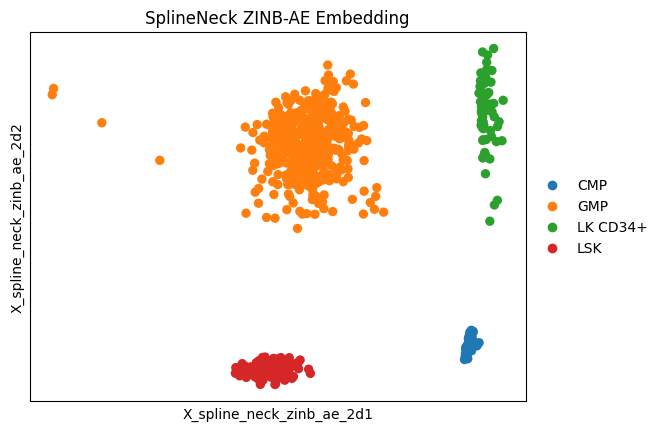

In [ ]:
import scanpy as sc
import warnings

# --- 1. Setup ---
# Filter out warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Define the AnnData object and the key we used
adata_to_plot = adata_new_counts
obsm_key = 'X_spline_neck_zinb_ae_2d'
latent_dim = adata_to_plot.obsm[obsm_key].shape[1]

print(f"Plotting embedding from adata_new_counts.obsm['{obsm_key}']")

# --- 2. Set Projection Type ---
# Set projection based on the latent_dim.
projection = None
if latent_dim == 3:
    projection = '3d'
    print("Plotting in 3D.")
elif latent_dim == 2:
     projection = '2d'
     print("Plotting in 2D.")
else:
    print(f"Warning: Cannot plot {latent_dim}-D embedding directly. Plotting first 2 components.")

# --- 3. Plot the Embedding ---
sc.pl.embedding(
    adata_to_plot,
    basis=obsm_key,
    color="celltype",      # Color the points by their ground-truth cell type
    projection=projection,
    title="SplineNeck ZINB-AE Embedding",
    show=True,
    save="_spline_neck_zinb_ae_embedding.png"
)